# Speech Understanding
## Assignment 1
#### Question 2A
### Akansha Gautam (M23CSA506)

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import IPython.display as ipd
import librosa.display
import torchaudio
import torchaudio.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

pd.set_option('display.max_colwidth', None)

# Set Device

In [2]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


# Load Urban Sound 8K Dataset

In [3]:
# Metadata file path
metadata_file = "/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/metadata/UrbanSound8K.csv"

# Audio directory path
audio_dir = "/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio"

In [4]:
# Load metadata_file
metadata = pd.read_csv(metadata_file)

metadata['file_path'] = audio_dir + '/' + 'fold' + metadata.fold.astype(str) + '/' + metadata['slice_file_name']

print(f"Metadata shape: {metadata.shape}")
metadata.head()

Metadata shape: (8732, 9)


,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio/fold5/100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio/fold5/100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio/fold5/100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,/Users/akanshagautam/Documents/MTech/Speech Understanding/Assignment 1/UrbanSound8K/audio/fold5/100263-2-0-137.wav


# Exploratory Data Analysis

In [5]:
# Show Metadata Dataframe information
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   file_path        8732 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 614.1+ KB


/var/folders/12/7zfx6db53p5bf6btn6s9bqy40000gn/T/ipykernel_6443/2908938374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=metadata, palette="husl")


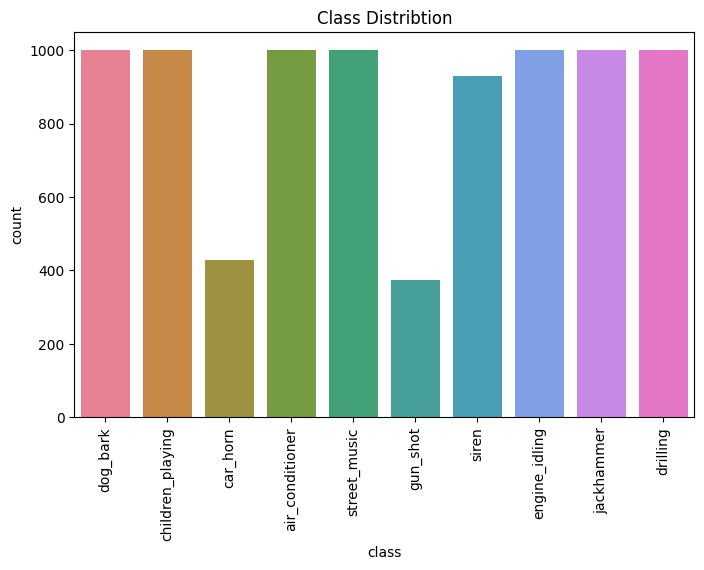

In [6]:
# Show the number of samples present of each class
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=metadata, palette="husl")
plt.title('Class Distribtion')
plt.xticks(rotation=90)
plt.show()

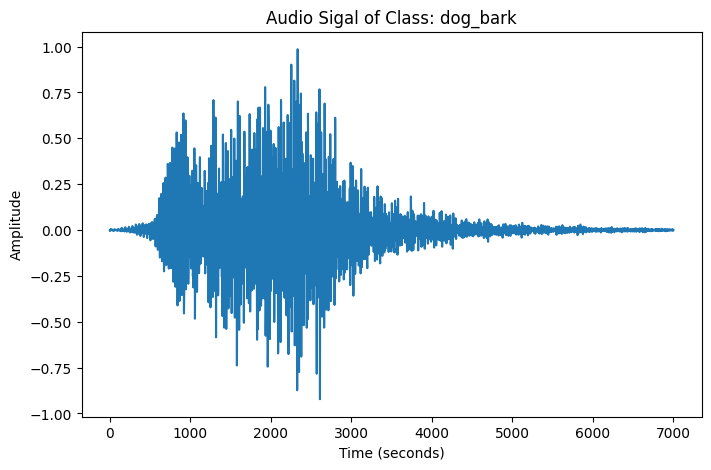

In [7]:
# Load wav file for class = dog_bark
metadata_dog_bark = metadata[metadata['class'] == 'dog_bark'][['class', 'file_path']]
x, _ = librosa.load(metadata_dog_bark.iloc[0]['file_path'])
plt.figure(figsize=(8,5))
plt.title(f"Audio Sigal of Class: {metadata_dog_bark.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)

ipd.Audio(metadata_dog_bark.iloc[0]['file_path'])

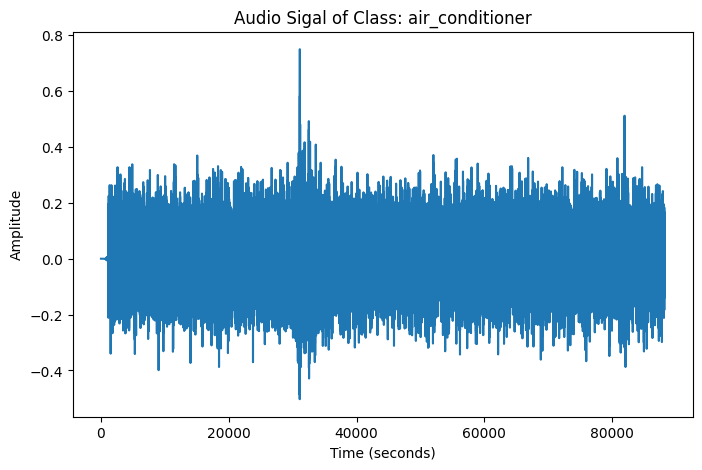

In [8]:
# Load wav file for class = air_conditioner
metadata_air_conditioner = metadata[metadata['class'] == 'air_conditioner'][['class', 'file_path']]
x, _ = librosa.load(metadata_air_conditioner.iloc[0]['file_path'])
plt.figure(figsize=(8,5))
plt.title(f"Audio Sigal of Class: {metadata_air_conditioner.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)

ipd.Audio(metadata_air_conditioner.iloc[0]['file_path'])

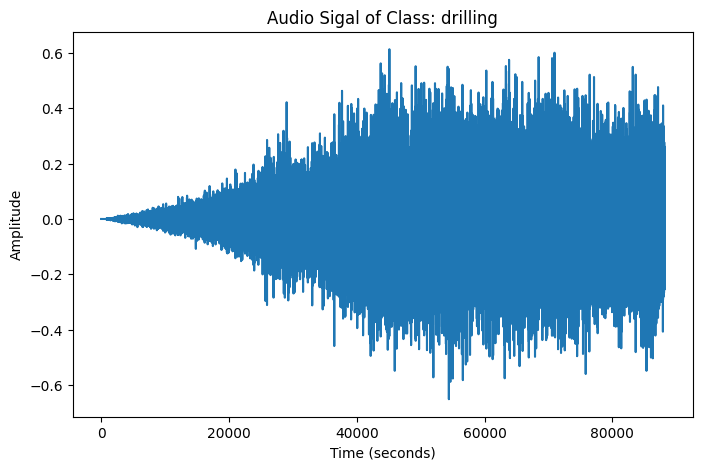

In [9]:
# Load wav file for class = drilling
metadata_drilling = metadata[metadata['class'] == 'drilling'][['class', 'file_path']]
x, _ = librosa.load(metadata_drilling.iloc[0]['file_path'])
plt.figure(figsize=(8,5))
plt.title(f"Audio Sigal of Class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.plot(x)

ipd.Audio(metadata_drilling.iloc[0]['file_path'])

# Implement Windowing Techniques

## Hann Window

In [24]:
def get_hann_window(signal_length):
    hann_window = []
    for i in range(0, signal_length):
        hann_window.append(0.5 * (1 - np.cos((2 * np.pi * i)/(signal_length-1))))
    return hann_window

def apply_hann_window(signal, hann_window):
    return signal * hann_window
    

signal, sample_rate = librosa.load(metadata[metadata['class'] == 'drilling'].iloc[0]['file_path'])
print(f"Audio Signal: {signal}")
print(f"Audio Signal Length: {signal.shape}")
print(f"Sample Rate: {sample_rate}")
print()

hann_window = get_hann_window(len(signal))
hann_windowed_signal = apply_hann_window(signal, hann_window)

print(f"Hann Windowed Audio Signal: {hann_windowed_signal}")
print(f"Hann Windowed Audio Signal Length: {hann_windowed_signal.shape}")


Audio Signal: [-5.4569682e-12 -3.6379788e-12  0.0000000e+00 ... -1.3928816e-01
 -1.5356672e-01 -1.2940323e-01]
Audio Signal Length: (88200,)
Sample Rate: 22050

Hann Windowed Audio Signal: [-0.00000000e+00 -4.61564702e-21  0.00000000e+00 ... -7.06881487e-10
 -1.94836144e-10 -0.00000000e+00]
Hann Windowed Audio Signal Length: (88200,)


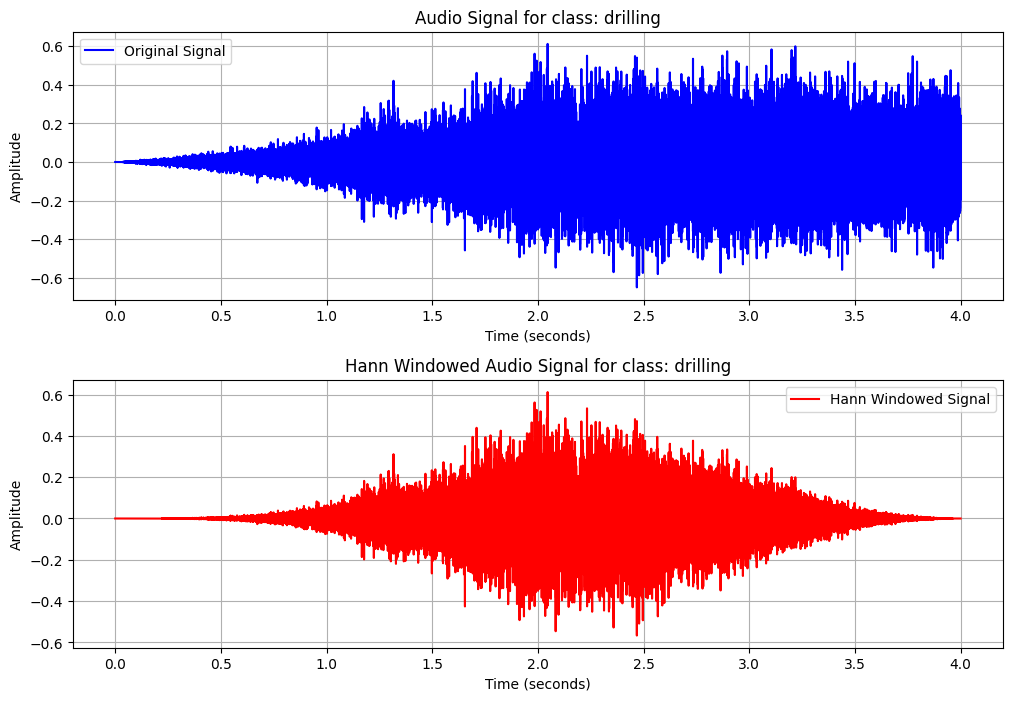

In [25]:
# Visual comparison of audio signal when applied hann windowing technique
time = np.arange(len(signal)) / sample_rate

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, signal, color='b', label='Original Signal')
plt.title(f"Audio Signal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, hann_windowed_signal, color='r', label='Hann Windowed Signal')
plt.title(f"Hann Windowed Audio Signal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

## Hamming Window

In [12]:
def get_hamming_window(signal_length):
    hamming_window = []
    for i in range(0, signal_length):
        hamming_window.append(0.54 - 0.46 * np.cos((2 * np.pi * i)/(signal_length-1)))
    return hamming_window

def apply_hamming_window(signal, hamming_window):
    return signal * hamming_window
    

signal, sample_rate = librosa.load(metadata[metadata['class'] == 'drilling'].iloc[0]['file_path'])
print(f"Audio Signal: {signal}")
print(f"Audio Signal Length: {signal.shape}")
print(f"Sample Rate: {sample_rate}")
print()

hamming_window = get_hamming_window(len(signal))
hamming_windowed_signal = apply_hamming_window(signal, hamming_window)

print(f"Hamming Windowed Audio Signal: {hamming_windowed_signal}")
print(f"Hamming Windowed Audio Signal Length: {hamming_windowed_signal.shape}")

Audio Signal: [-5.4569682e-12 -3.6379788e-12  0.0000000e+00 ... -1.3928816e-01
 -1.5356672e-01 -1.2940323e-01]
Audio Signal Length: (88200,)
Sample Rate: 22050

Hamming Windowed Audio Signal: [-4.36557457e-13 -2.91038309e-13  0.00000000e+00 ... -1.11430532e-02
 -1.22853376e-02 -1.03522587e-02]
Hamming Windowed Audio Signal Length: (88200,)


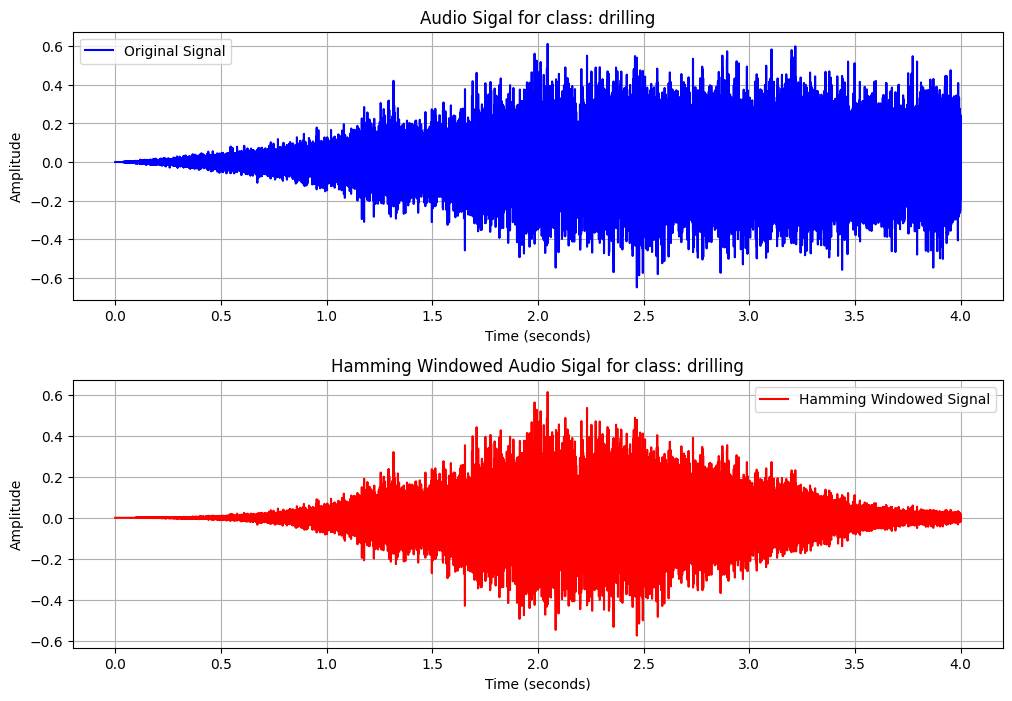

In [13]:
# Visual comparison of audio signal when applied hamming windowing technique
time = np.arange(len(signal)) / sample_rate

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, signal, color='b', label='Original Signal')
plt.title(f"Audio Sigal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, hamming_windowed_signal, color='r', label='Hamming Windowed Signal')
plt.title(f"Hamming Windowed Audio Sigal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

## Rectangular Window

In [14]:
def get_rectangular_window(signal_length):
    return np.ones(signal_length)

def apply_rectangular_window(signal, rectangular_window):
    return signal * rectangular_window
    

signal, sample_rate = librosa.load(metadata[metadata['class'] == 'drilling'].iloc[0]['file_path'])
print(f"Audio Signal: {signal}")
print(f"Audio Signal Length: {signal.shape}")
print(f"Sample Rate: {sample_rate}")
print()

rectangular_window = get_rectangular_window(len(signal))
rectangular_windowed_signal = apply_rectangular_window(signal, rectangular_window)

print(f"Rectangular Windowed Audio Signal: {rectangular_windowed_signal}")
print(f"Rectangular Windowed Audio Signal Length: {rectangular_windowed_signal.shape}")

Audio Signal: [-5.4569682e-12 -3.6379788e-12  0.0000000e+00 ... -1.3928816e-01
 -1.5356672e-01 -1.2940323e-01]
Audio Signal Length: (88200,)
Sample Rate: 22050

Rectangular Windowed Audio Signal: [-5.45696821e-12 -3.63797881e-12  0.00000000e+00 ... -1.39288157e-01
 -1.53566718e-01 -1.29403234e-01]
Rectangular Windowed Audio Signal Length: (88200,)


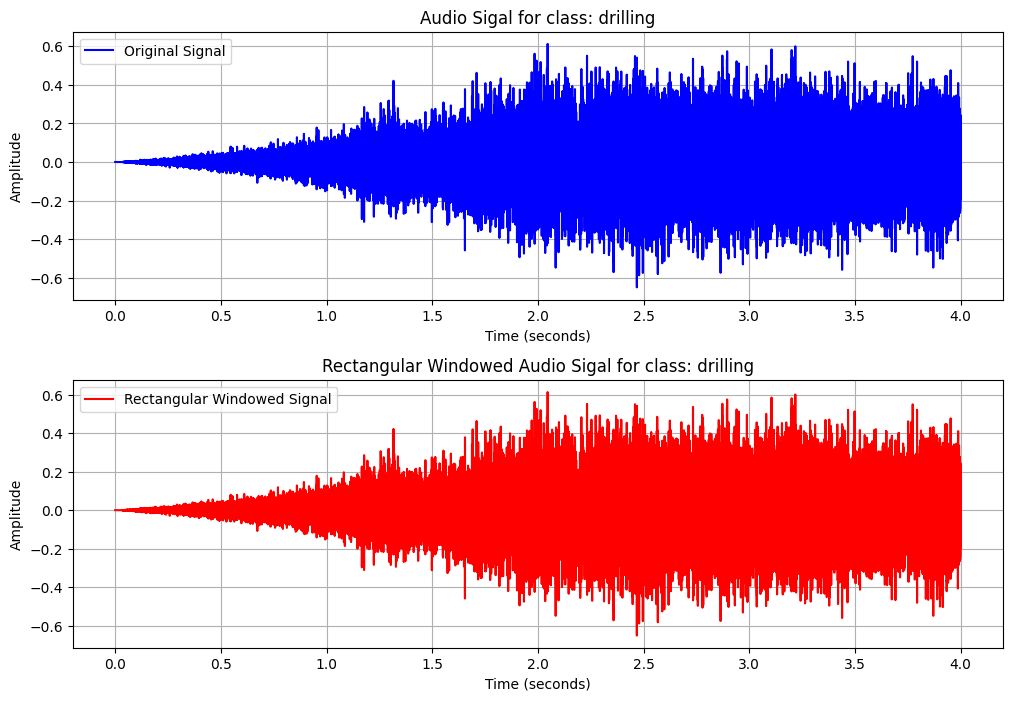

In [15]:
# Visual comparison of audio signal when applied rectangular windowing technique
time = np.arange(len(signal)) / sample_rate

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(time, signal, color='b', label='Original Signal')
plt.title(f"Audio Sigal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, rectangular_windowed_signal, color='r', label='Rectangular Windowed Signal')
plt.title(f"Rectangular Windowed Audio Sigal for class: {metadata_drilling.iloc[0]['class']}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.3)
plt.show()

# Short-Time Fourier Transform (STFT)

In [39]:
hop_length = 512
win_length = 1024

signal, sample_rate = librosa.load(metadata[metadata['class'] == 'gun_shot'].iloc[0]['file_path'])
print(f"Audio Signal: {signal}")
print(f"Audio Signal Length: {signal.shape}")
print(f"Sample Rate: {sample_rate}")
print()

rectangular_window = get_rectangular_window(win_length)
hann_window = get_hann_window(win_length)
hamming_window = get_hamming_window(win_length)

stft_rectangular = librosa.stft(signal, n_fft=win_length, hop_length=hop_length, win_length=win_length, window=rectangular_window)
stft_hann = librosa.stft(signal, n_fft=win_length, hop_length=hop_length, win_length=win_length, window=hann_window)
stft_hamming = librosa.stft(signal, n_fft=win_length, hop_length=hop_length, win_length=win_length, window=hamming_window)

Audio Signal: [-1.5772879e-05  5.2932650e-04  9.9615753e-04 ... -3.9790393e-13
  2.8421709e-14 -1.8118840e-13]
Audio Signal Length: (57551,)
Sample Rate: 22050



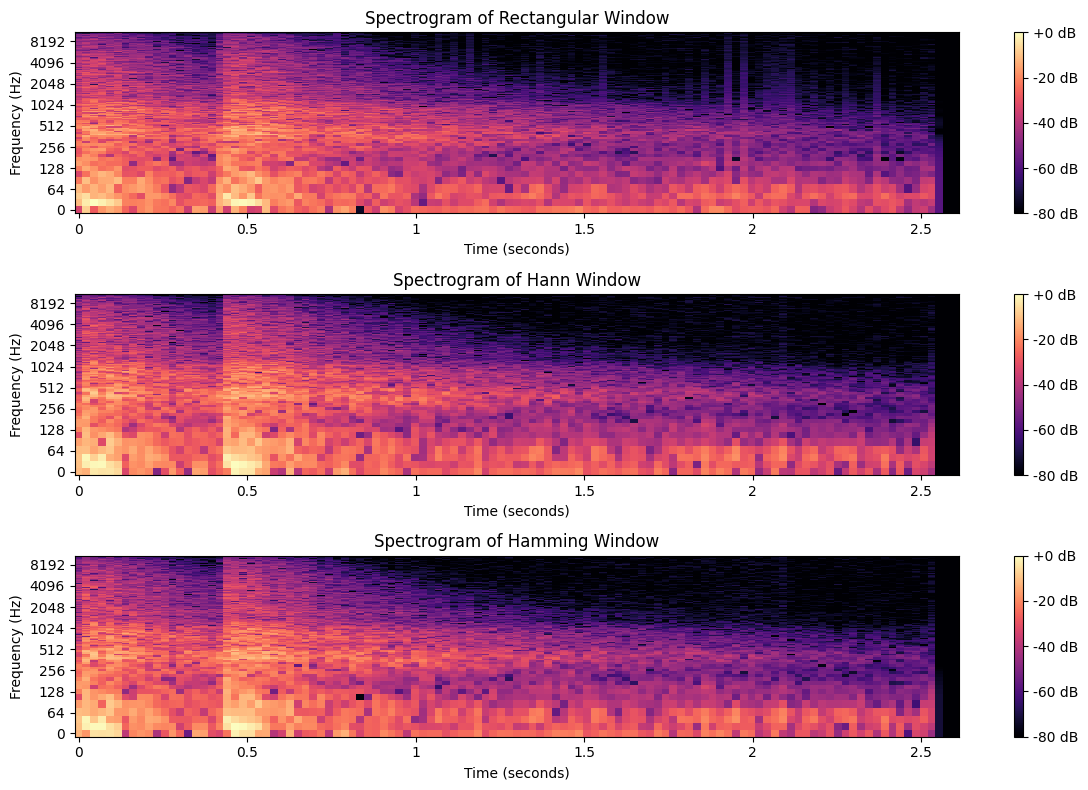

In [40]:
# Visualise the comparison of spectrograms
stft_rectangular_db = librosa.amplitude_to_db(np.abs(stft_rectangular), ref=np.max)
stft_hann_db = librosa.amplitude_to_db(np.abs(stft_hann), ref=np.max)
stft_hamming_db = librosa.amplitude_to_db(np.abs(stft_hamming), ref=np.max)

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(stft_rectangular_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of Rectangular Window")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")

plt.subplot(3, 1, 2)
librosa.display.specshow(stft_hann_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of Hann Window")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")

plt.subplot(3, 1, 3)
librosa.display.specshow(stft_hamming_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram of Hamming Window")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

# Train a Classifier 

In [18]:
def extract_stft_features(file_path, window_type, target_duration=4, sample_rate=44100, win_length=1024, hop_length=512):

    if window_type == "hann":
        window = get_hann_window(win_length)
    elif window_type == "hamming":
        window = get_hamming_window(win_length)
    else:
        window = get_rectangular_window(win_length)

    signal, current_sample_rate = librosa.load(file_path, sr=sample_rate)
    target_length = int(target_duration * current_sample_rate)

    if (len(signal) < target_length):
        signal = np.pad(signal, (0, target_length - len(signal)), mode='constant')
    else:
        signal = signal[:target_length]

    stft = librosa.stft(signal, n_fft=win_length, hop_length=hop_length, win_length=win_length, window=window)

    stft_magnitude = np.abs(stft)
    features = stft_magnitude.flatten()
    return features

def encode_labels(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    return labels_encoded, label_encoder

def train_and_evaluate_svm(X_train, X_test, y_train, y_test, window_type, n_components=100):

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

    print(f"Train Features shape: {X_train.shape}")
    print(f"Train Labels shape: {y_train.shape}")
    print(f"Test Features shape: {X_test.shape}")
    print(f"Test Labels shape: {y_test.shape}")

    svm_classifier = SVC(kernel='linear', random_state=42)
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)

    print(f"Classification Report for {window_type} window:")
    print(classification_report(y_test, y_pred))

    print(f"Accuracy for {window_type} window:")
    print(accuracy_score(y_test, y_pred))

def run_svm(metadata, window_type):
    labels_encoded, _ = encode_labels(metadata['class'])
    all_features = []
    for i in range(metadata.shape[0]):
        file_path = metadata.iloc[i]['file_path']
        features = extract_stft_features(file_path=file_path, window_type=window_type)
        all_features.append(features)

    all_features = np.array(all_features)
    X_train, X_test, y_train, y_test = train_test_split(all_features, labels_encoded, test_size=0.2, random_state=42)
    train_and_evaluate_svm(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, window_type=window_type)


## Train a Classifier for Hann Window

In [19]:
run_svm(metadata=metadata, window_type='hann')

Train Features shape: (6985, 100)
Train Labels shape: (6985,)
Test Features shape: (1747, 100)
Test Labels shape: (1747,)
Classification Report for hann window:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       203
           1       0.68      0.78      0.73        86
           2       0.39      0.63      0.48       183
           3       0.57      0.61      0.59       201
           4       0.64      0.66      0.65       206
           5       0.62      0.51      0.56       193
           6       0.78      0.65      0.71        72
           7       0.80      0.67      0.73       208
           8       0.75      0.73      0.74       165
           9       0.59      0.43      0.49       230

    accuracy                           0.60      1747
   macro avg       0.63      0.62      0.62      1747
weighted avg       0.62      0.60      0.60      1747

Accuracy for hann window:
0.5998855180309102


## Train a Classifier for Hamming Window


In [20]:
run_svm(metadata=metadata, window_type='hamming')

Train Features shape: (6985, 100)
Train Labels shape: (6985,)
Test Features shape: (1747, 100)
Test Labels shape: (1747,)
Classification Report for hamming window:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       203
           1       0.67      0.79      0.73        86
           2       0.40      0.63      0.49       183
           3       0.58      0.60      0.59       201
           4       0.64      0.67      0.66       206
           5       0.57      0.48      0.52       193
           6       0.82      0.71      0.76        72
           7       0.79      0.67      0.73       208
           8       0.78      0.74      0.76       165
           9       0.60      0.46      0.52       230

    accuracy                           0.61      1747
   macro avg       0.64      0.63      0.63      1747
weighted avg       0.62      0.61      0.61      1747

Accuracy for hamming window:
0.6050372066399542


## Train a Classifier for Rectangular Window

In [21]:
run_svm(metadata=metadata, window_type='rectangular')

Train Features shape: (6985, 100)
Train Labels shape: (6985,)
Test Features shape: (1747, 100)
Test Labels shape: (1747,)
Classification Report for rectangular window:
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       203
           1       0.64      0.79      0.71        86
           2       0.39      0.65      0.48       183
           3       0.60      0.53      0.56       201
           4       0.60      0.61      0.61       206
           5       0.60      0.50      0.55       193
           6       0.84      0.68      0.75        72
           7       0.74      0.70      0.72       208
           8       0.68      0.66      0.67       165
           9       0.59      0.41      0.48       230

    accuracy                           0.58      1747
   macro avg       0.62      0.61      0.60      1747
weighted avg       0.60      0.58      0.59      1747

Accuracy for rectangular window:
0.5832856325128792
